In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 26,
                    'figure.max_open_warning': 200})
import numpy as np
import pandas as pd
import urllib.request

from date_utils import readable_date, get_date_format

In [12]:
# Load Data.
# Thanks to the Covid Tracking Project for collecting excellent data.
url = 'http://covidtracking.com/api/states/daily.csv'
urllib.request.urlretrieve(url, 'Data/states-daily.csv')
df = pd.read_csv("Data/states-daily.csv", sep=',', header=0)
df_vals = df.values

abbrevs_df = pd.read_csv("Data/state_abbreviations.csv", sep=',', header=0)
state_abbrevs = {
    state : abbrev for [state, abbrev] in abbrevs_df.values
}
state_full_names = {
    abbrev: state for [state, abbrev] in abbrevs_df.values
}
census_df = pd.read_csv("Data/state_populations.csv", sep=',', header=0)
# Population data from:
# Table 1. Annual Estimates of the Resident Population for the United States, Regions, States, and Puerto Rico: April 1, 2010 to July 1, 2019 (NST-EST2019-01)
state_pops = {
    state_abbrevs[state].replace(' ', '_'): int(pop.replace(',', '')) for [state, pop] in census_df.values
}

In [13]:
# Helper functions to read the dataframe.
def get_idx(state, date):
    i = np.where(df_vals[:, df.columns.tolist().index('state')] == state)[0]
    j = np.where(df_vals[:, df.columns.tolist().index('date')] == date)[0]
    return set(i).intersection(set(j)).pop()
    
def get_val(state, date, col_name):
    idx = get_idx(state, date)
    return df[[col_name]].values[idx]

def get_positive(state, date):
    return get_val(state, date, 'positive')

def get_negative(state, date):
    return get_val(state, date, 'negative')

def get_total(state, date):
    return get_val(state, date, 'total')

In [14]:
# The main part of the model to estimate total number of infections.
def calc_sum_z(N, num_pos, num_neg, c):
    try:
        return (N*num_pos) / (c*num_neg + num_pos)
    except:
        return (N*num_pos) / (c(N, num_pos, num_neg)*num_neg + num_pos)

def get_latent_total(state, date, c):
    return calc_sum_z(state_pops[state], get_positive(state, date), get_negative(state, date), c)

In [15]:
# Dates to plot in the graph
dates = [get_date_format(d, 3, 2020) for d in range(16, 32)] # march dates (before the 16th many did not report negative test counts)
dates.extend([get_date_format(d, 4, 2020) for d in range(1, 31)]) # april dates
dates.extend([get_date_format(d, 5, 2020) for d in range(1, 3)]) # may dates
readable_dates = list(map(readable_date, dates))
n_dates = len(dates)
print(readable_dates)

['3/16', '3/17', '3/18', '3/19', '3/20', '3/21', '3/22', '3/23', '3/24', '3/25', '3/26', '3/27', '3/28', '3/29', '3/30', '3/31', '4/1', '4/2', '4/3', '4/4', '4/5', '4/6', '4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16', '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27', '4/28', '4/29', '4/30', '5/1', '5/2']


In [16]:
# Shared plotting helpers.
markers = ['.', '+', '*', '^']

def finalize_plot(dates, y_label, fname, separate_legend=True):
    plt.xlim([0, len(dates)-1])
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs], fontsize=28)
    plt.xlabel("Date", fontsize=40)
    plt.ylabel(y_label, fontsize=40)
    plt.yticks(fontsize=28)
    if not separate_legend:
        lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
        plt.savefig(fname, dpi=300, bbox_inches='tight', bbox_artists=[lgd])
    else:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
        def export_legend(legend, filename):
            fig  = legend.figure
            fig.canvas.draw()
            bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(filename, dpi=300, bbox_inches=bbox)
        export_legend(lgd, "results/legend.pdf")
    
def plot_pos_neg_pop(state, dates):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', color='black', marker='+')
    plt.semilogy(positives, label='Cumulative Positive Tests', color='red', marker='+')
    plt.semilogy(negatives, label='Cumulative Negative Tests', color='green', marker='+')
    
def logistic(x_min, x_max, y_min, y_max, j, slope):
    x_range = x_max - x_min
    x_mid = (x_max + x_min) / 2
    return y_min + (y_max-y_min)*(1 / (1 + np.exp(-slope*(j - x_mid)/x_range)))

def linear(x_min, x_max, y_min, y_max, j):
    x_range = x_max - x_min
    return y_min + j*(y_max - y_min)/x_range

In [17]:
# Calc c based on serological studies
def calc_c(state, date, Z):
    pop = state_pops[state]
    pos = get_positive(state, date)
    neg = get_negative(state, date)
    return ((pop*pos) / (Z*neg) - (pos / neg))[0]

# Stanford study
c_stanford_lower  = calc_c("CA", dates[readable_dates.index("4/4")], 0.00094*state_pops["CA"])
c_stanford_mean   = calc_c("CA", dates[readable_dates.index("4/4")], 0.0089*state_pops["CA"])
c_stanford_upper  = calc_c("CA", dates[readable_dates.index("4/4")], 0.02*state_pops["CA"])
print(c_stanford_lower, c_stanford_mean, c_stanford_upper)

# NYC Study
c_nyc_mean = calc_c("NY", dates[readable_dates.index("4/21")], 0.139*state_pops["NY"]) 
#c_nyc_upper = calc_c("NY", dates[readable_dates.index("4/21")], 0.21*state_pops["NY"])
print(c_nyc_mean) #c_nyc_lower, c_nyc_upper)

c_nyc_new = calc_c("NY", dates[readable_dates.index("5/2")], 0.123*state_pops["NY"])
print("nyc_new", c_nyc_new)

c_idaho = calc_c("ID", dates[readable_dates.index("4/25")], 0.0179*state_pops["ID"])
print("c_idaho", c_idaho)

"""
# Miami study
c_flo = calc_c("FL", dates[readable_dates.index("4/23")], 0.06*state_pops["FL"])
print(c_flo)
"""

# Stanford - Manual
pop_sc = 1928000
pos_sc = 1148
neg_sc = 10912
stanford_min = 0.00094*pop_sc
stanford_max = 0.0167*pop_sc
stanford_mean = 0.0081*pop_sc
c_stanford_min = (pop_sc*pos_sc)/(stanford_min*neg_sc) - (pos_sc / neg_sc)
print(c_stanford_min)
c_stanford_max = (pop_sc*pos_sc)/(stanford_max*neg_sc) - (pos_sc / neg_sc)
print(c_stanford_max)
print((pop_sc*pos_sc)/(stanford_mean*neg_sc) - (pos_sc / neg_sc))

stanford_min_bd = 0.018*pop_sc
stanford_max_bd = 0.057*pop_sc
#stanford_mean = 0.0081*pop_sc
print((pop_sc*pos_sc)/(stanford_min_bd*neg_sc) - (pos_sc / neg_sc))
print((pop_sc*pos_sc)/(stanford_max_bd*neg_sc) - (pos_sc / neg_sc))
#print((pop_sc*pos_sc)/(stanford_mean*neg_sc) - (pos_sc / neg_sc))

stanford_min = stanford_min / pop_sc
stanford_max = stanford_max / pop_sc

125.71149970765974 13.171606851861634 5.795719653008637
3.9207550252377965
nyc_new 3.4539114359281355
c_idaho 5.865832356241311
111.81530386223248
6.194512002388185
12.883100720466311
5.739532420984034
1.7405013633791222


In [18]:
print(stanford_min)
print(stanford_max)

0.00094
0.0167


In [19]:
prevalence_bad_flu = 0.001
prevalence_flu = 0.01
prevalence_cold = 0.1
symptomatic_covid = 0.5

c_cold = symptomatic_covid / (prevalence_cold + prevalence_flu)
c_flu  = symptomatic_covid / (prevalence_flu)
c_bad_flu = symptomatic_covid / prevalence_bad_flu

AK
AZ
AR
CA
CO
CT
DE
DC
FL
GA
HI
ID
IL
IN
IA
KS
KY
LA
ME
MD
MA
MI
MN
MS
MO
MT
NE
NV
NH
NJ
NM
NY
NC
ND
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VT
VA
WA
WV
WI
WY


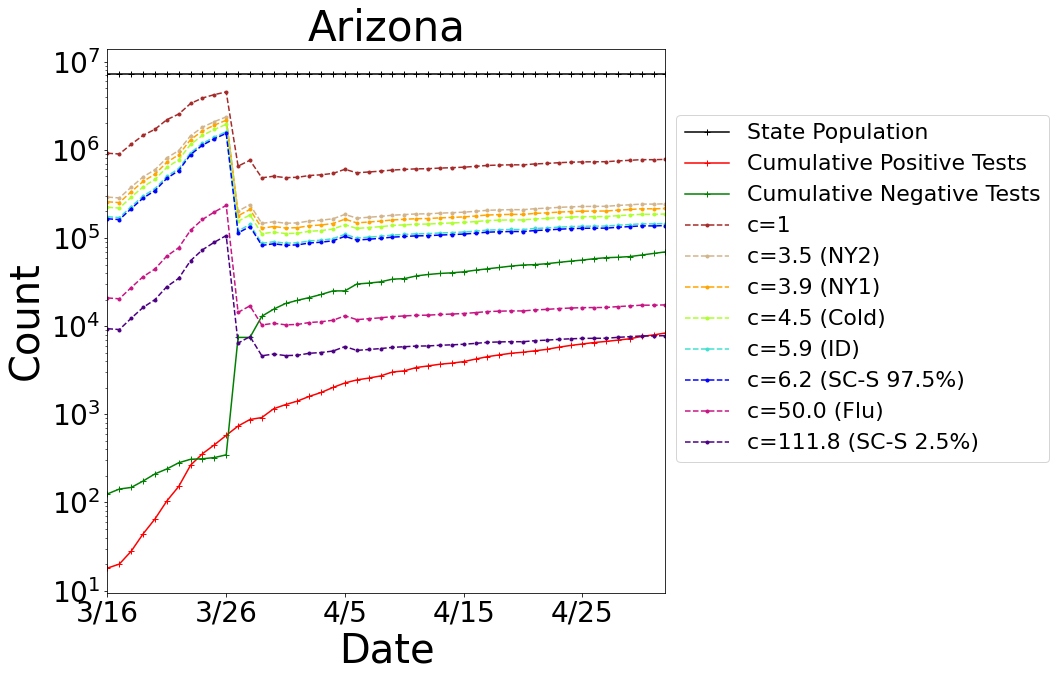

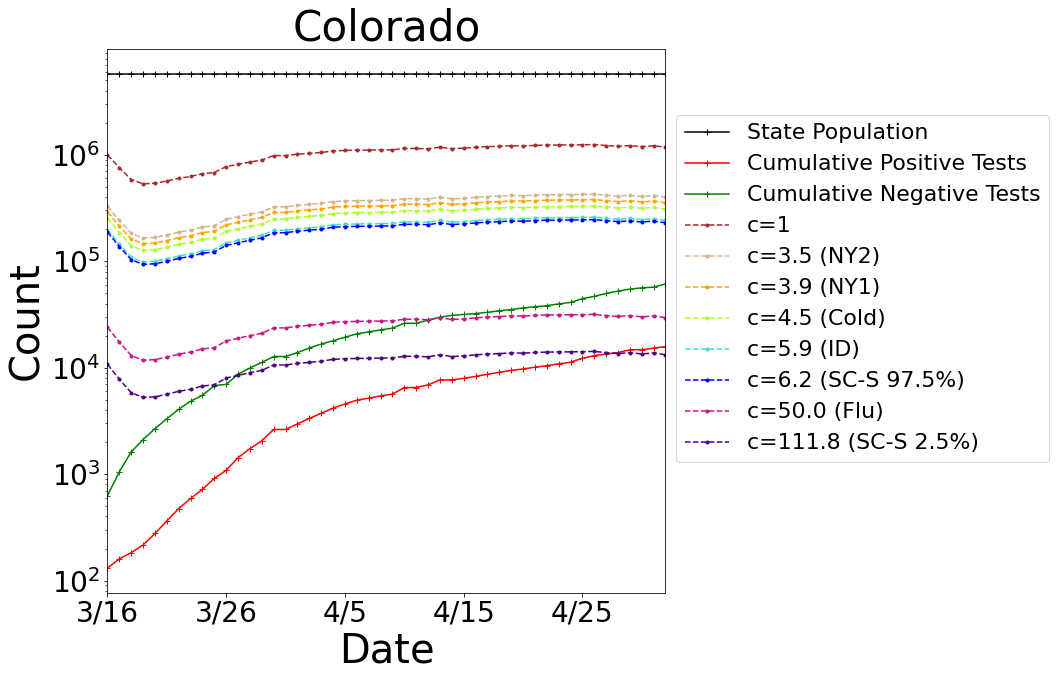

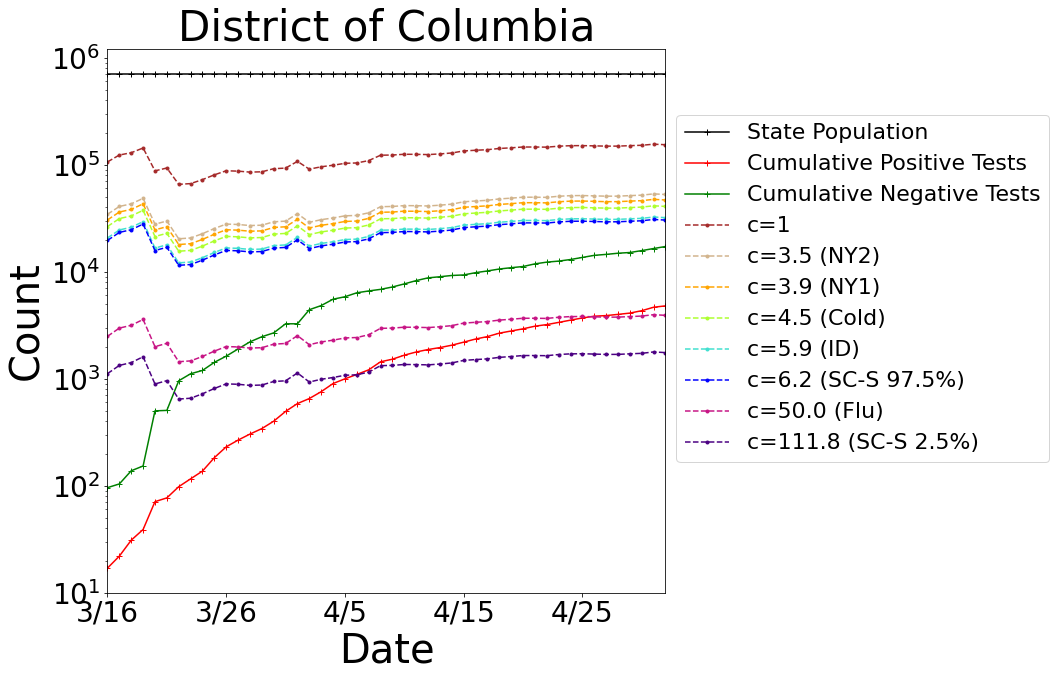

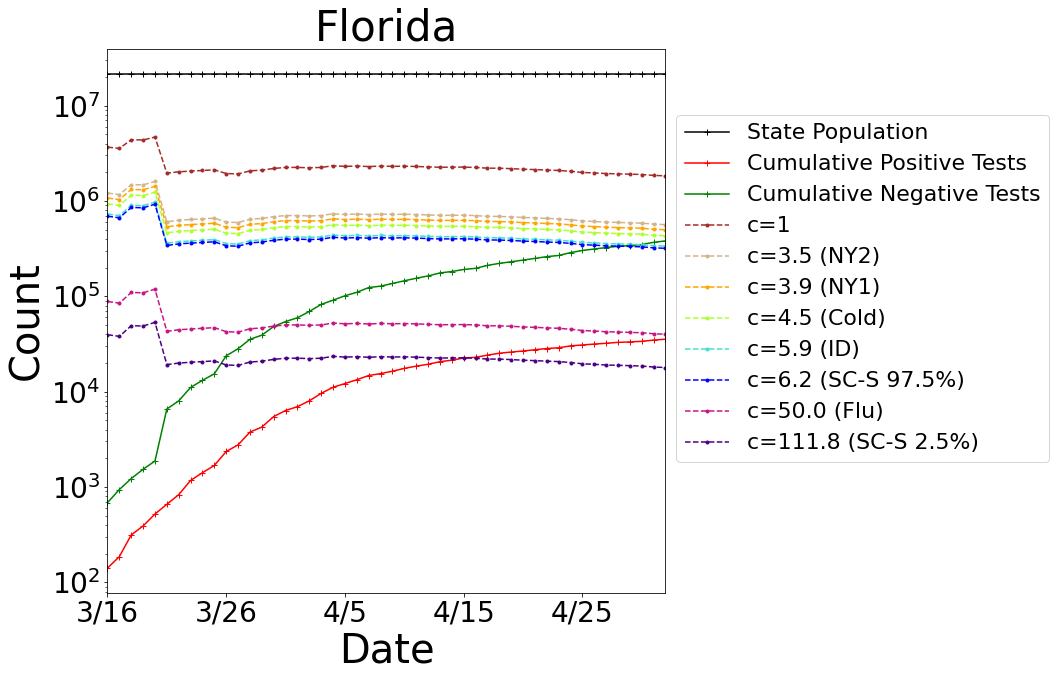

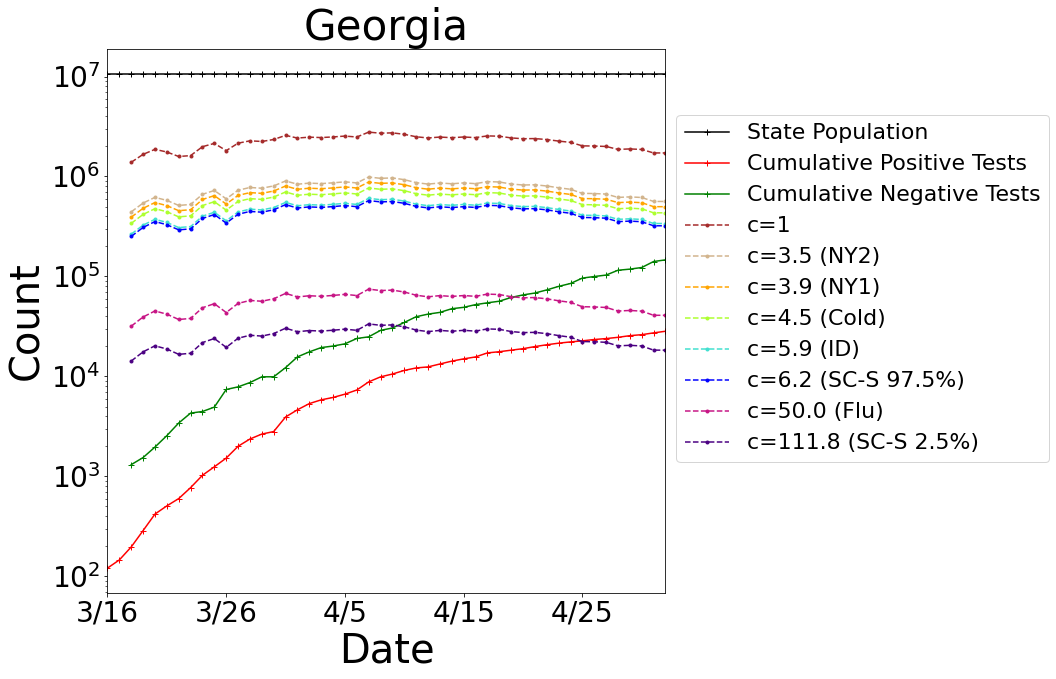

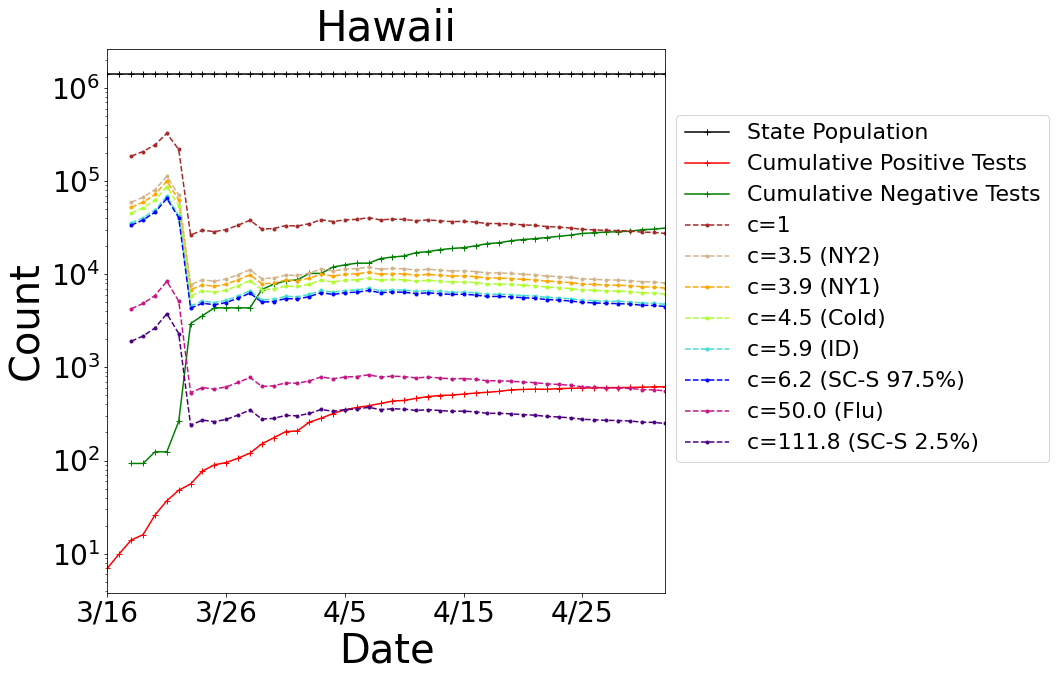

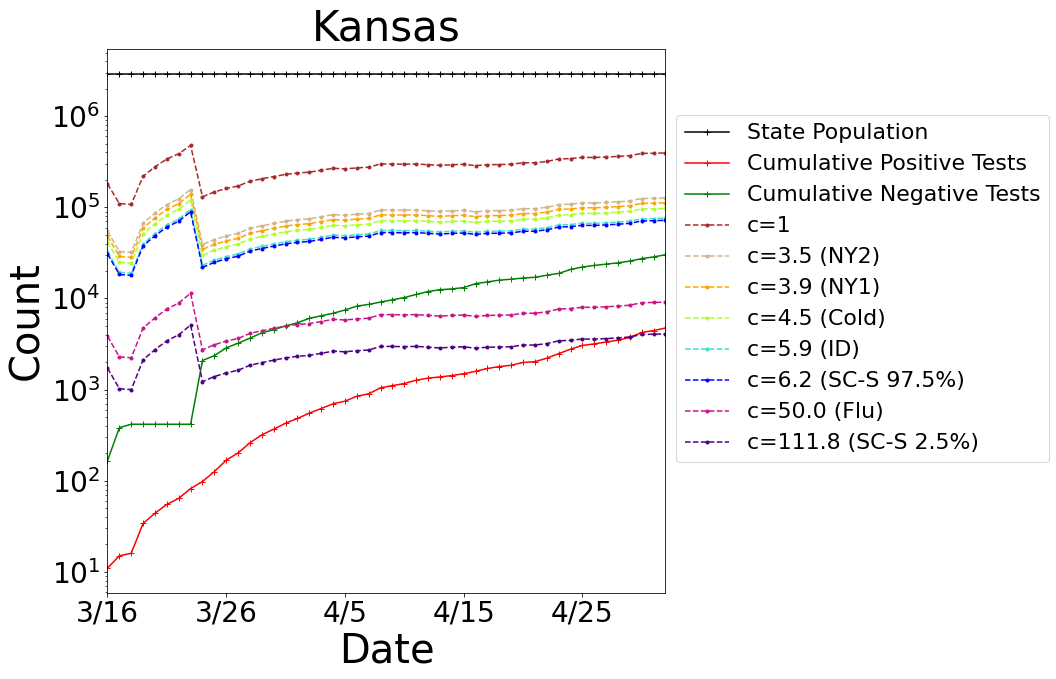

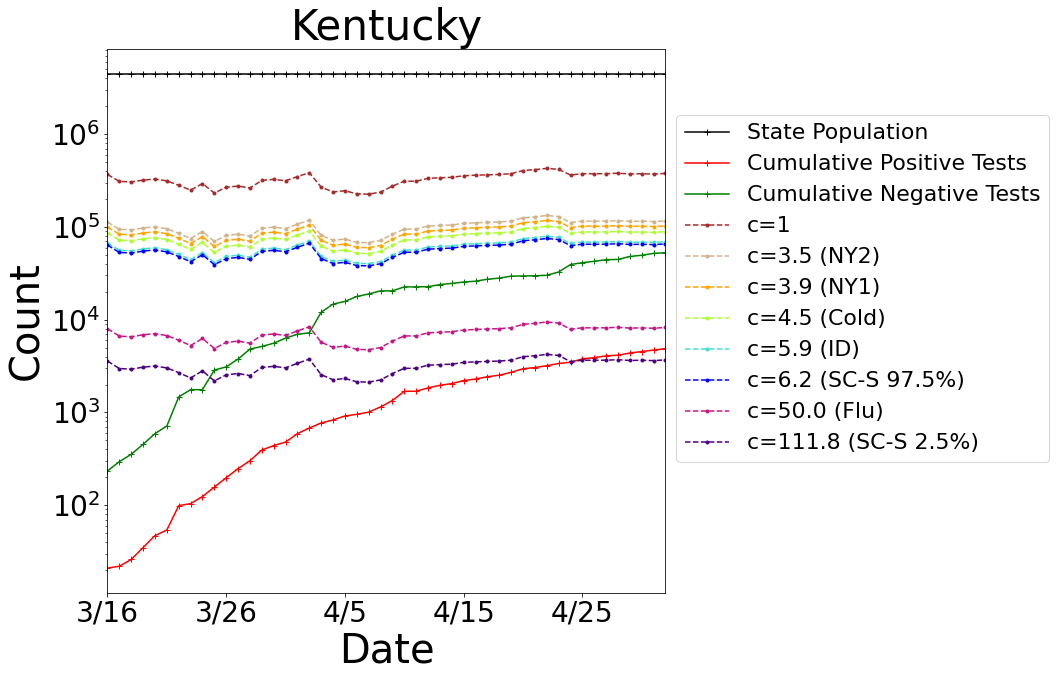

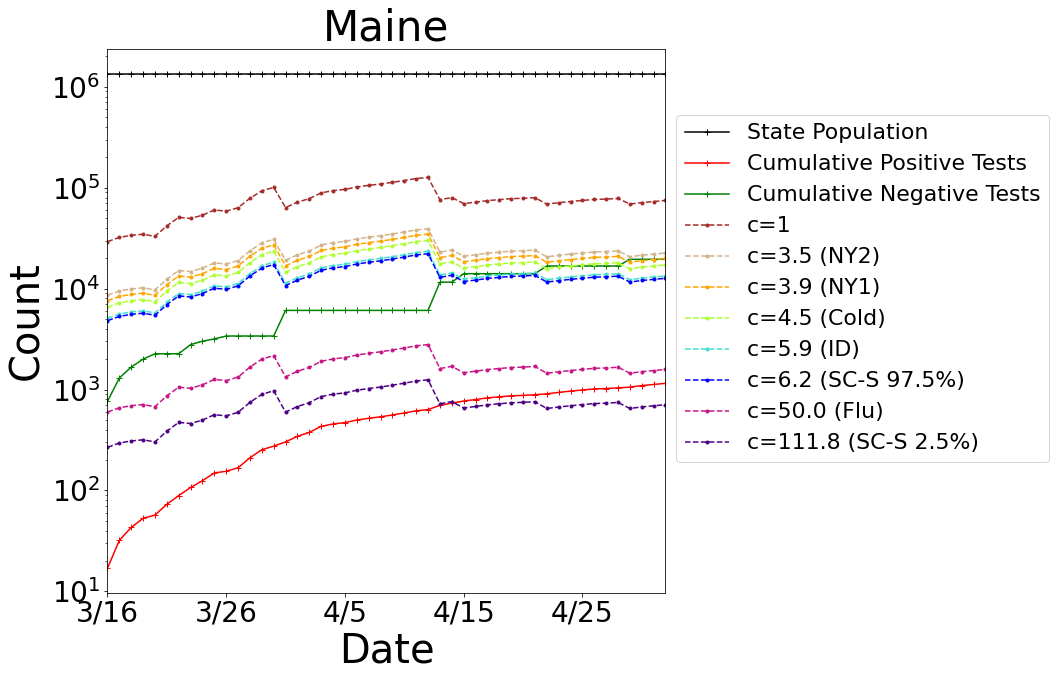

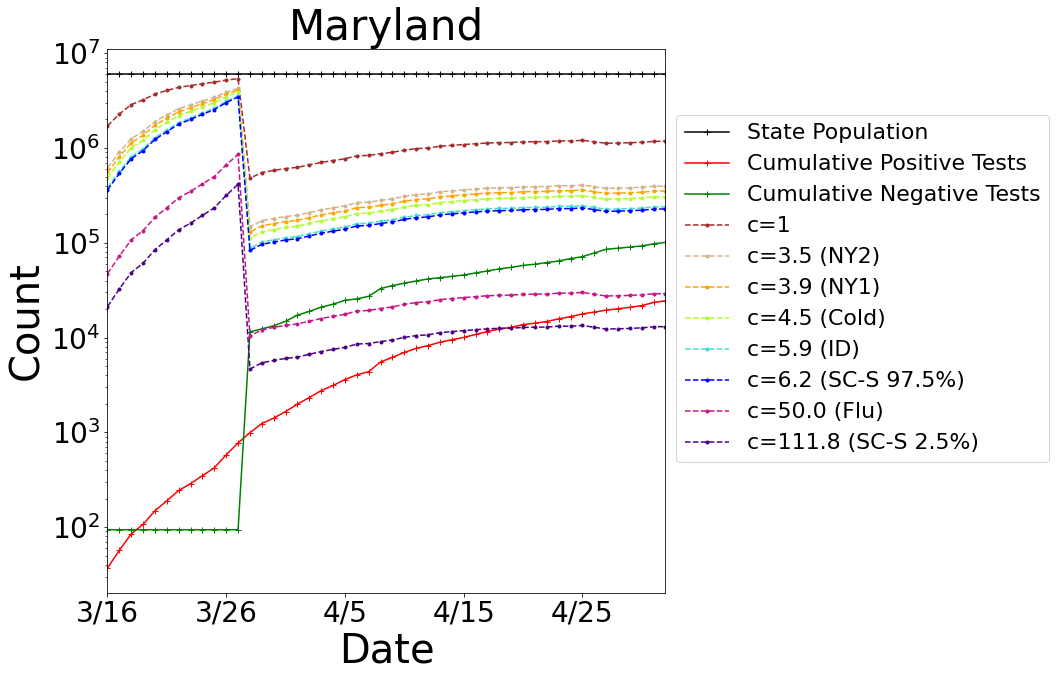

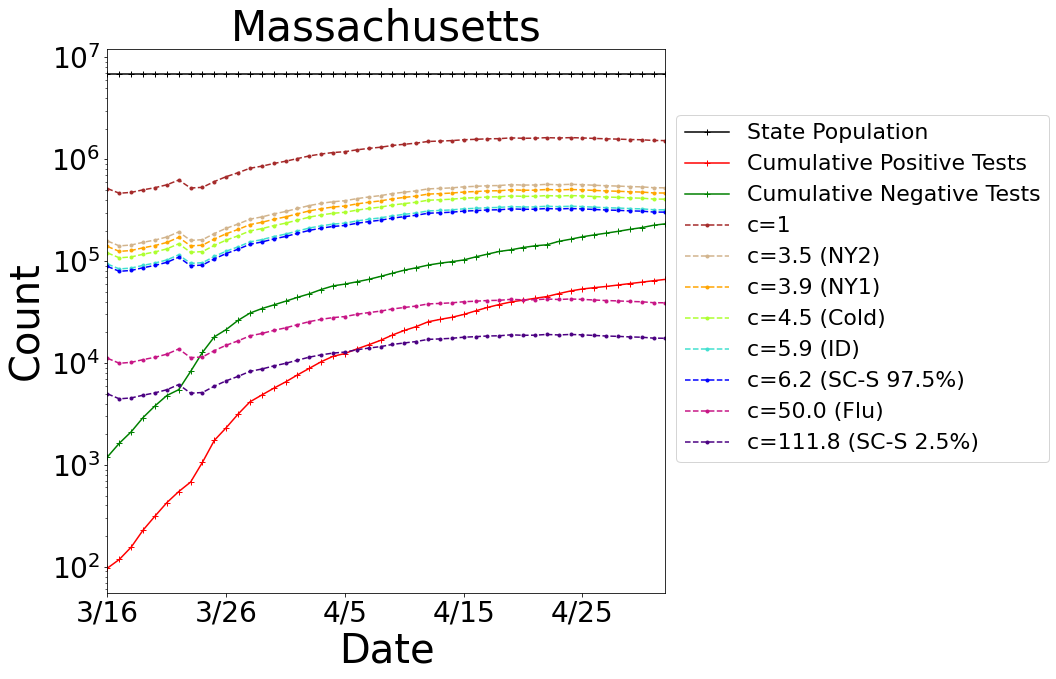

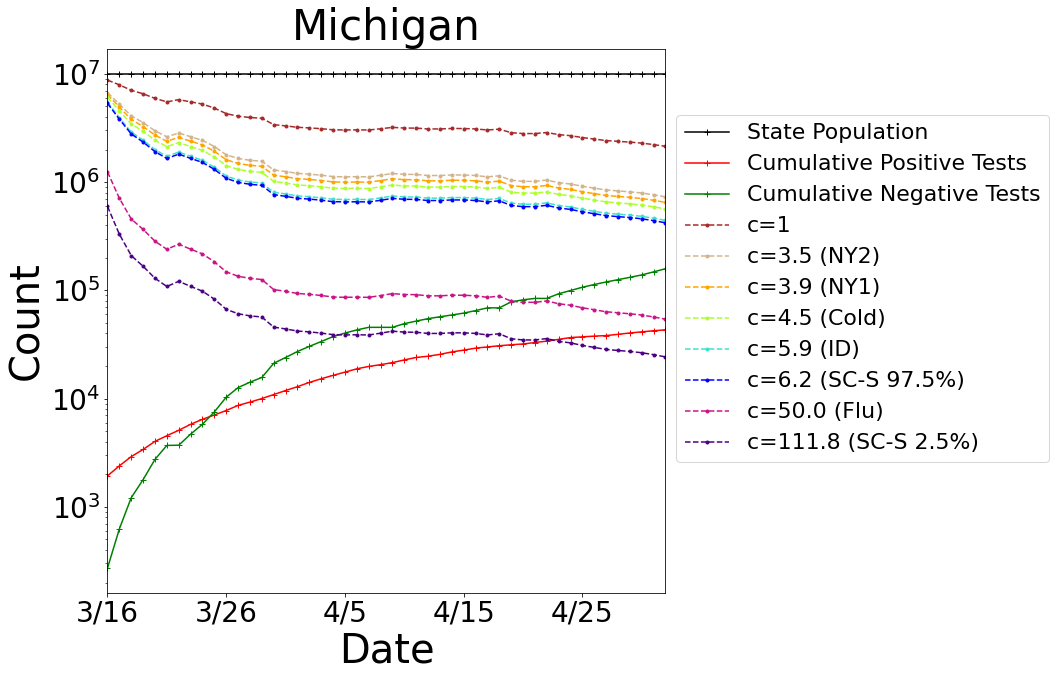

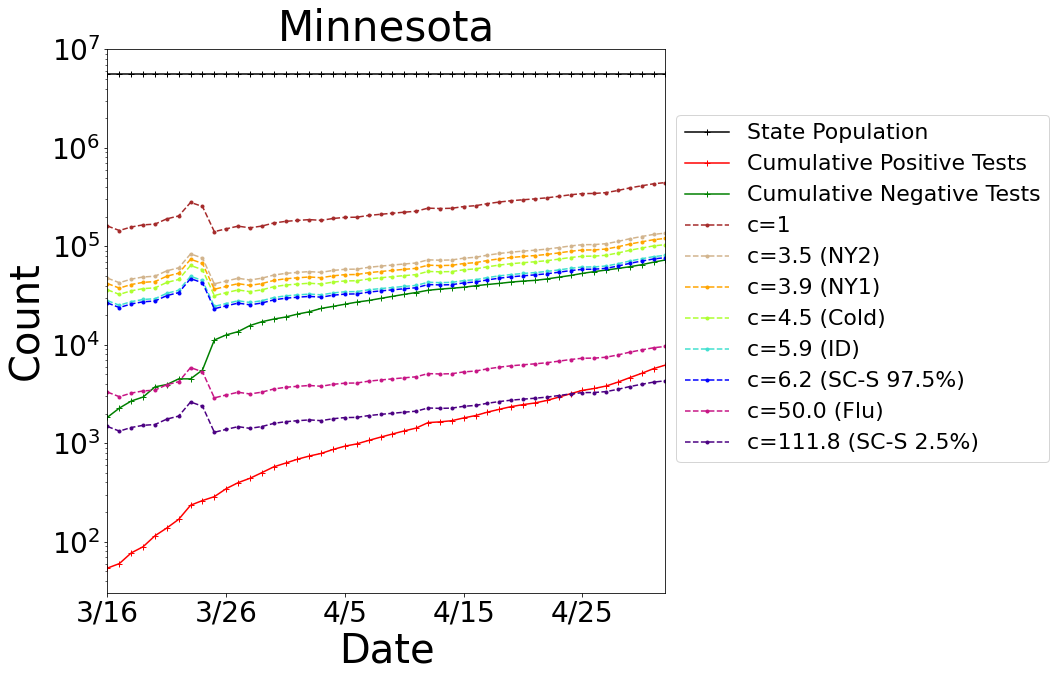

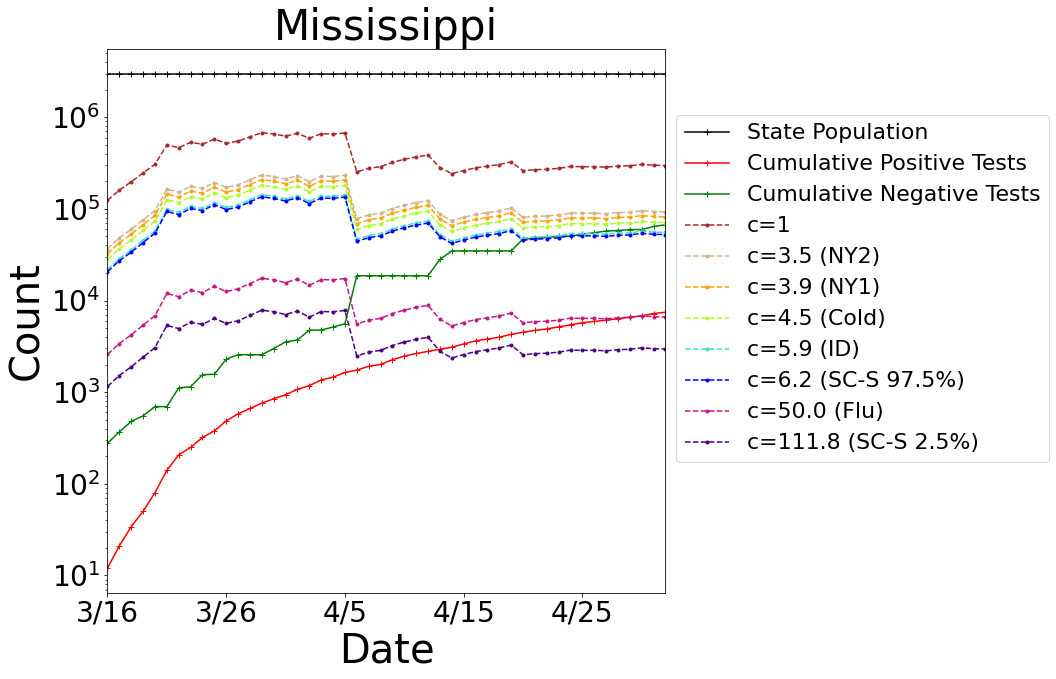

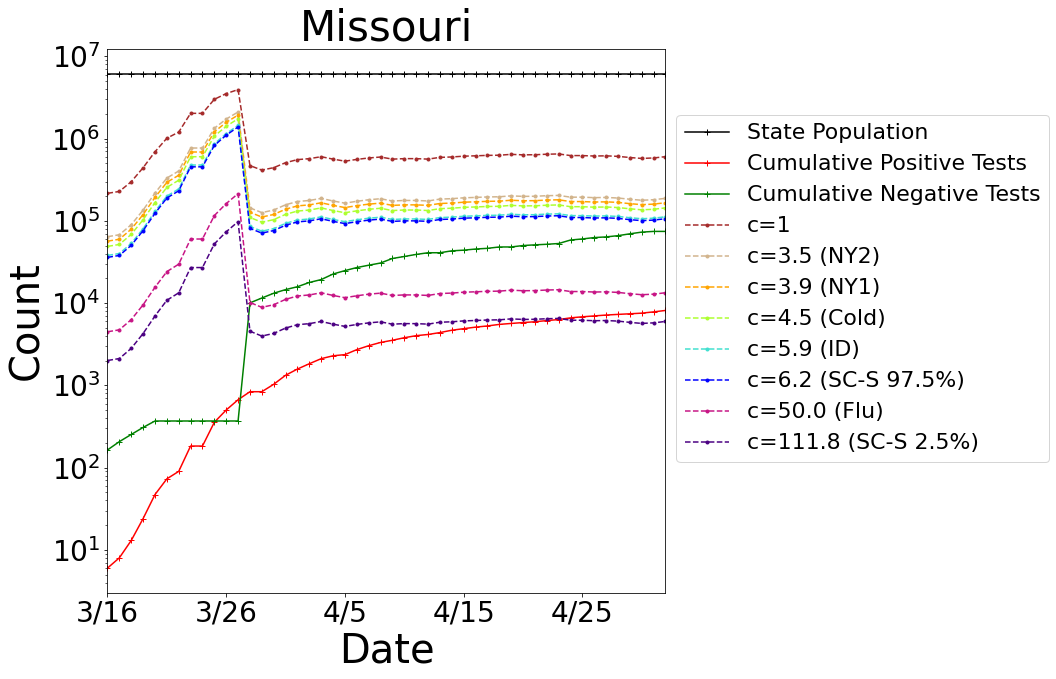

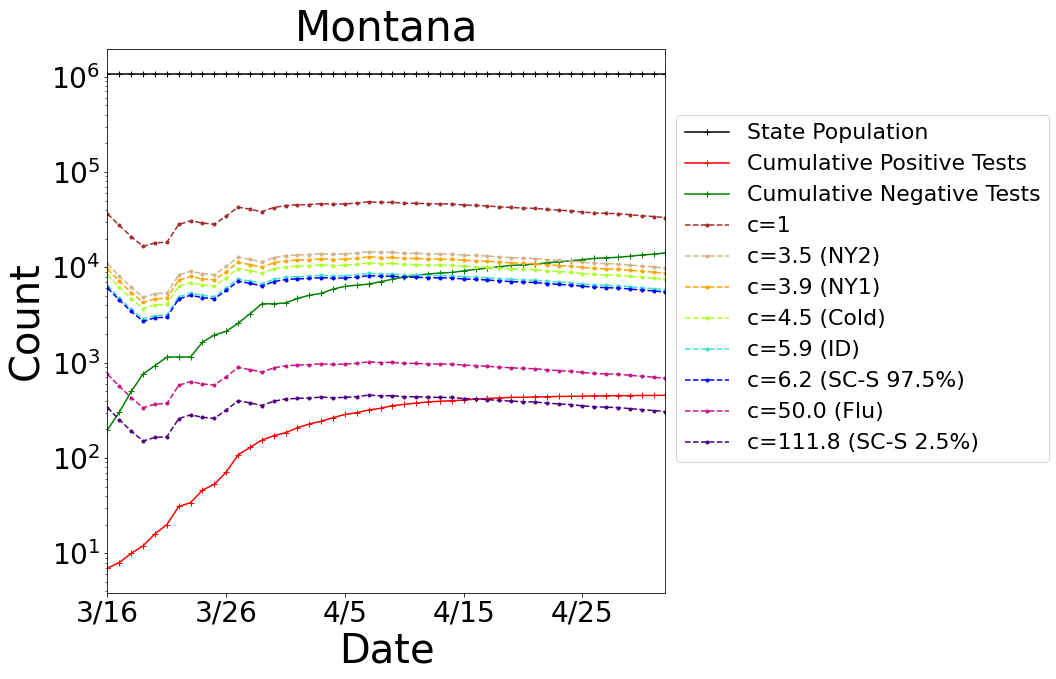

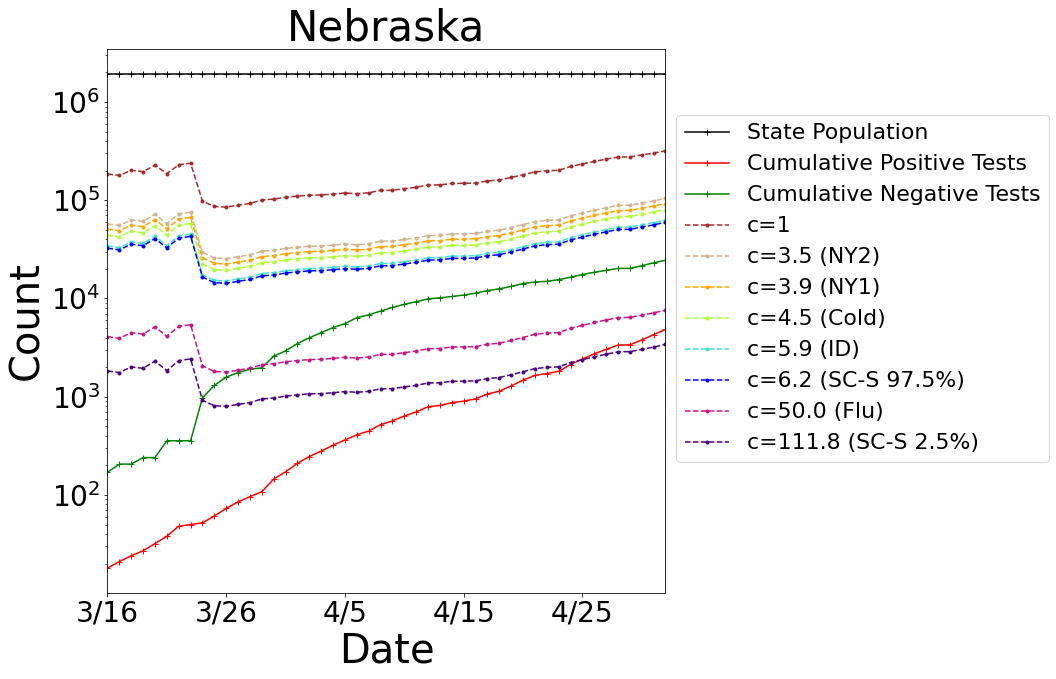

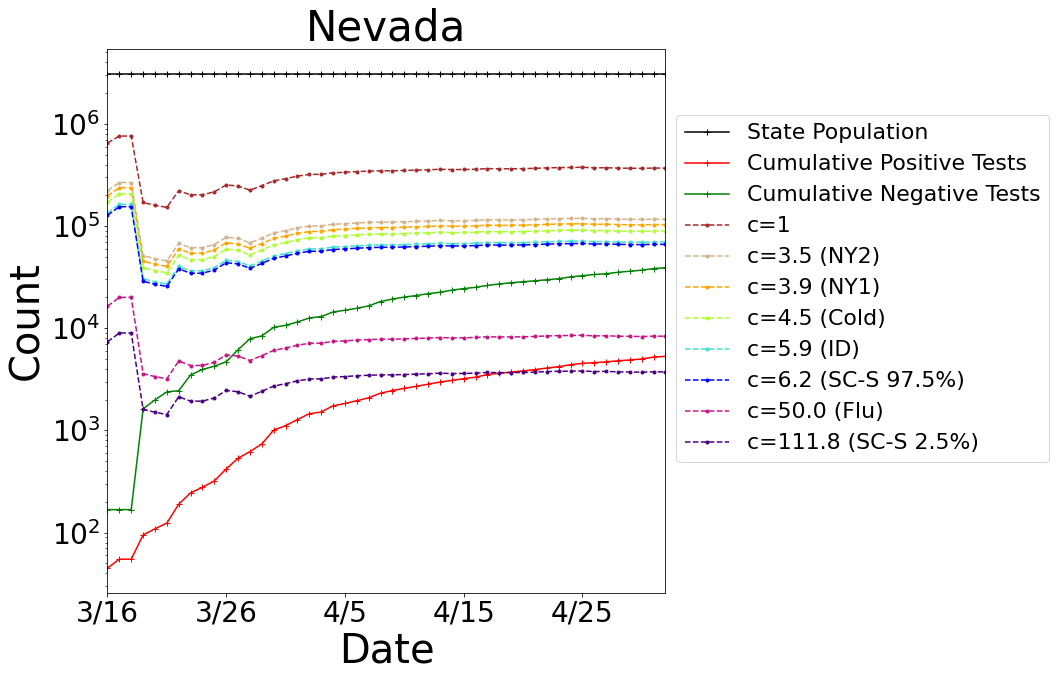

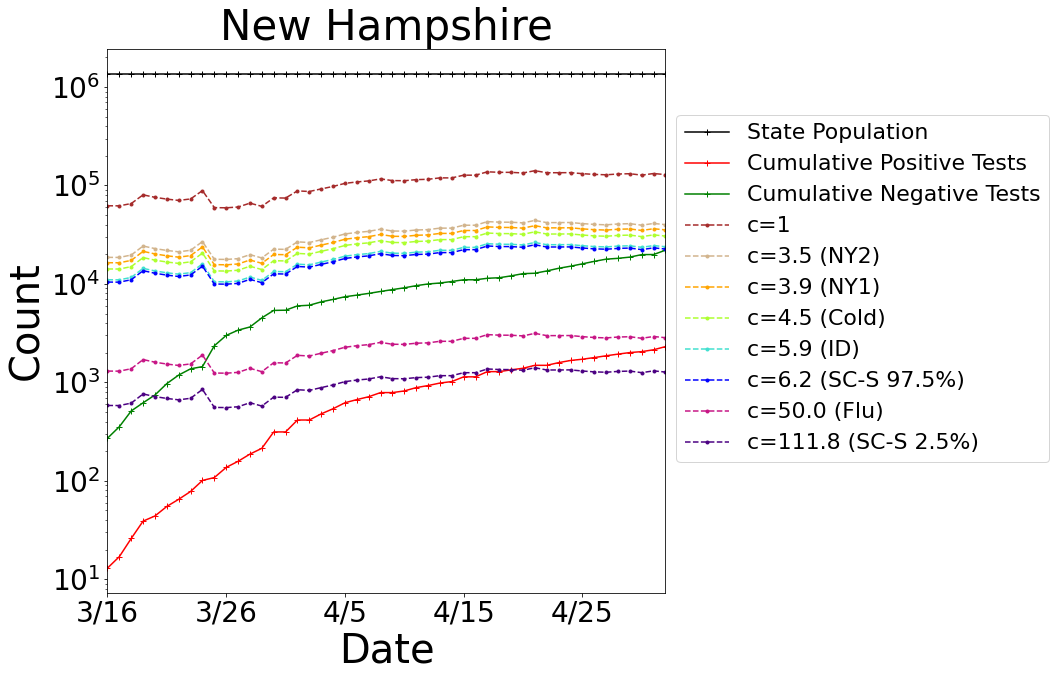

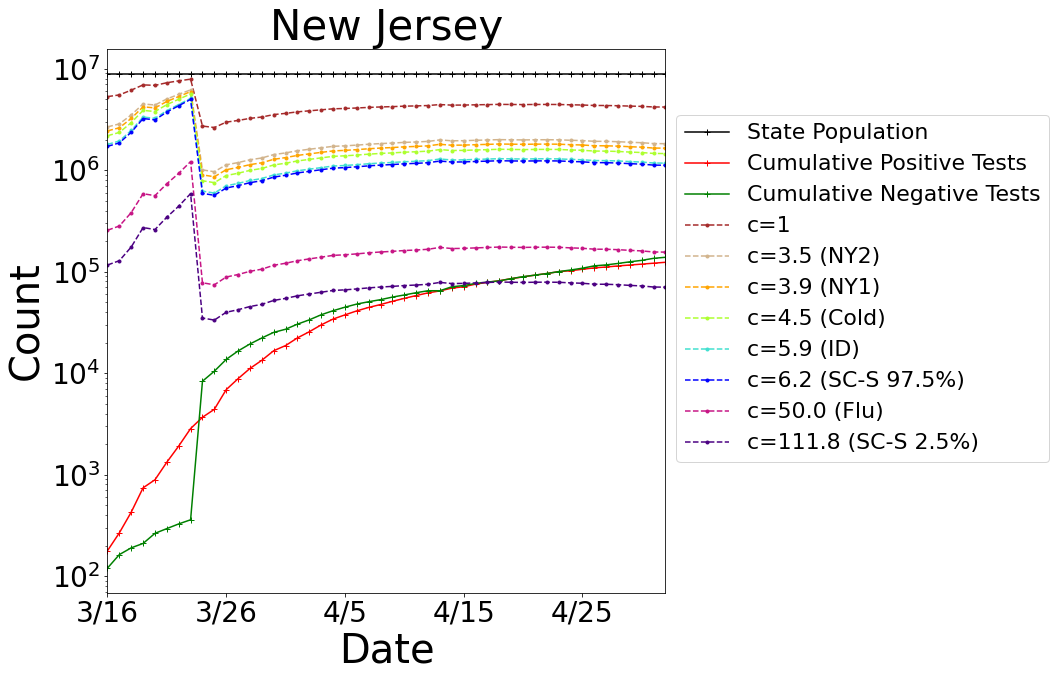

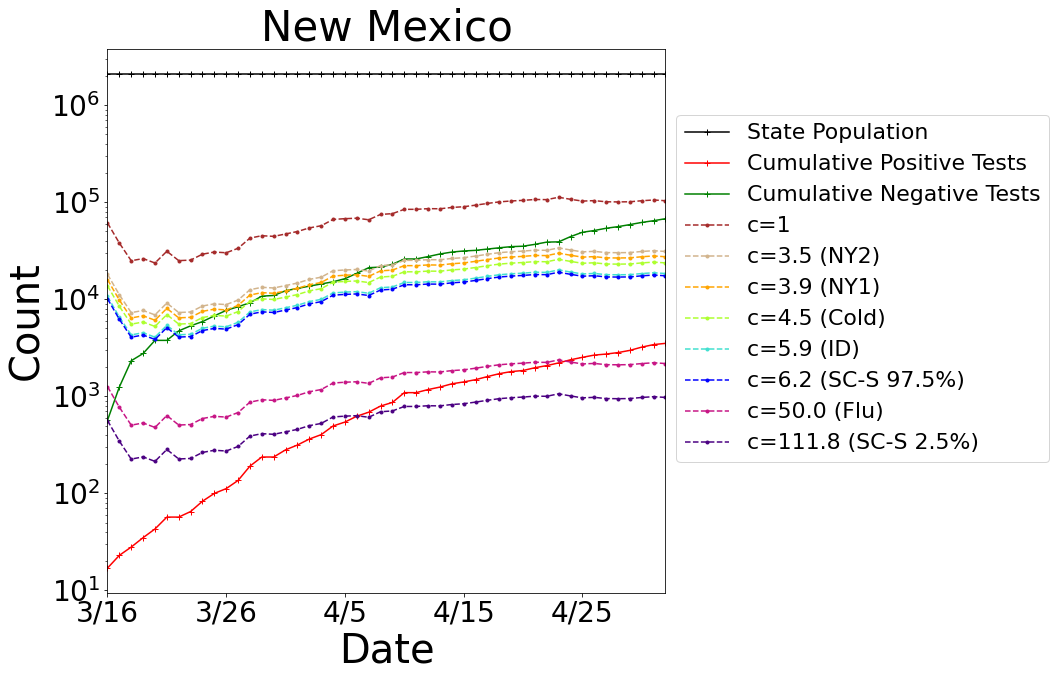

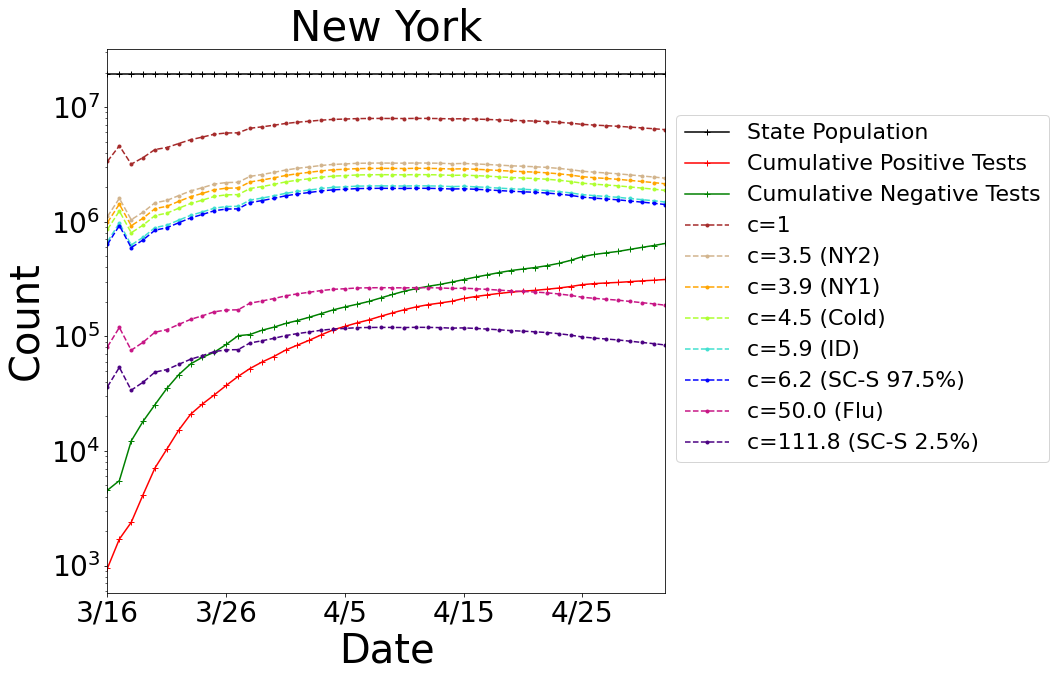

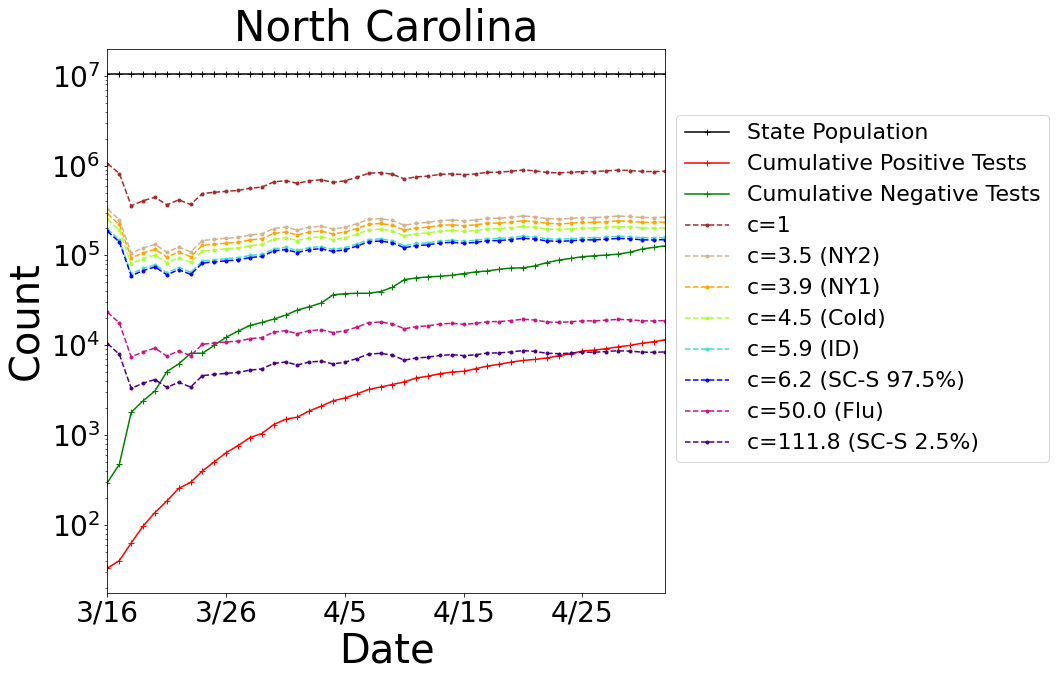

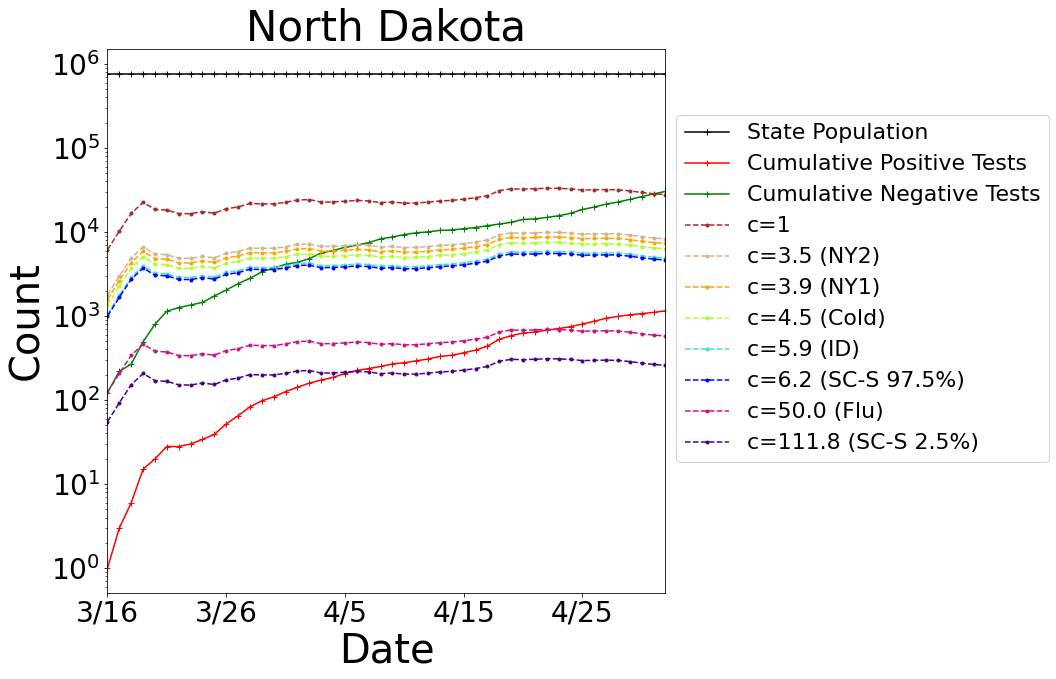

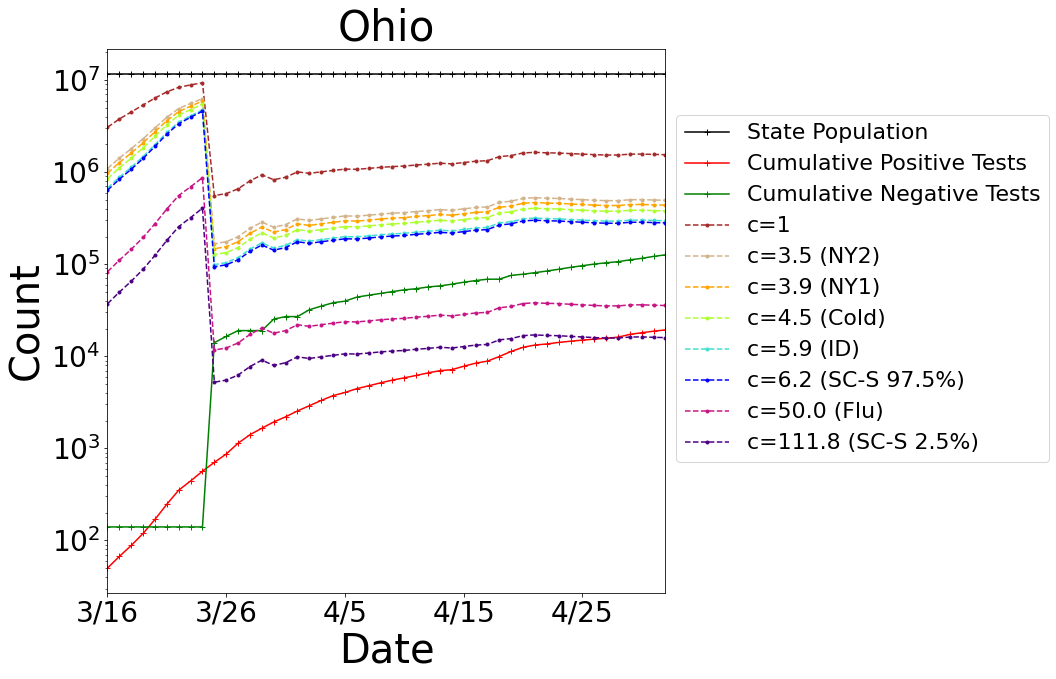

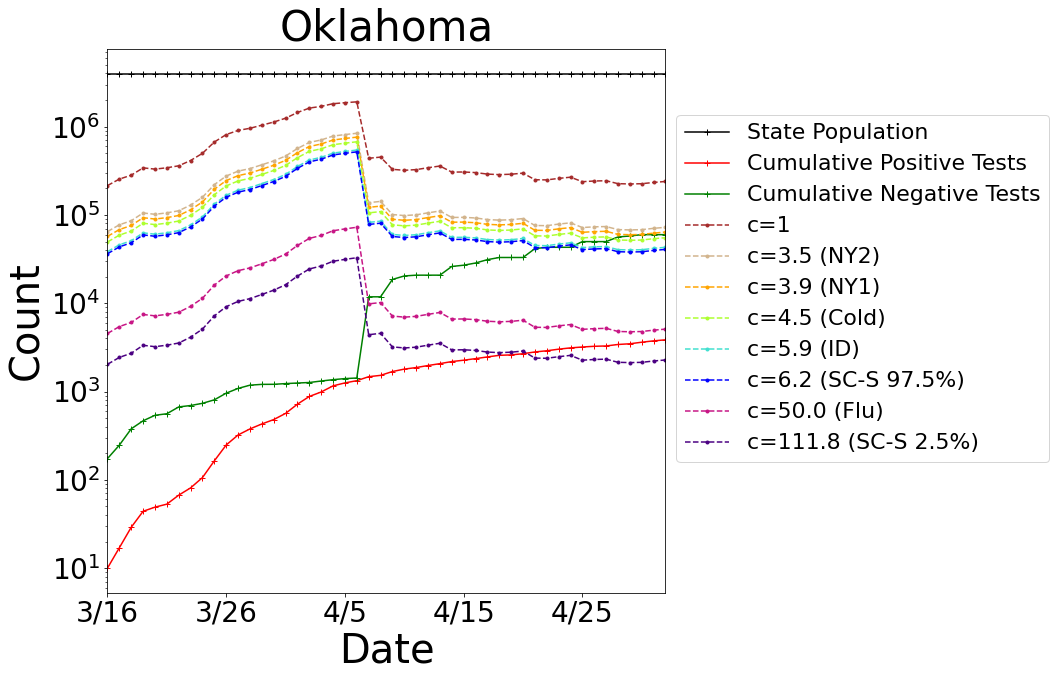

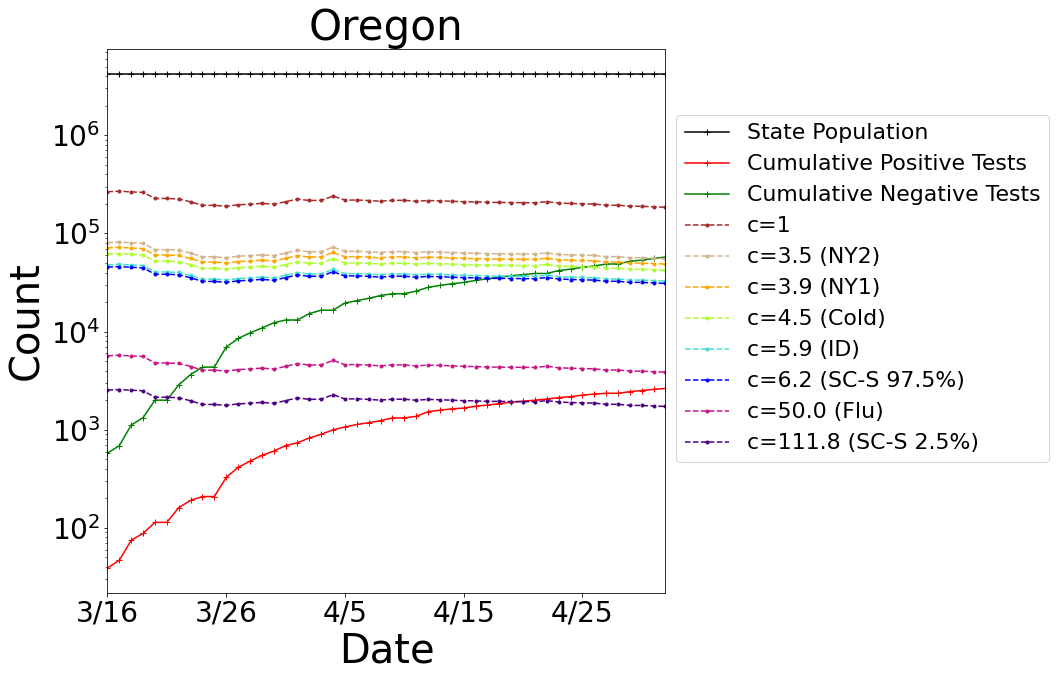

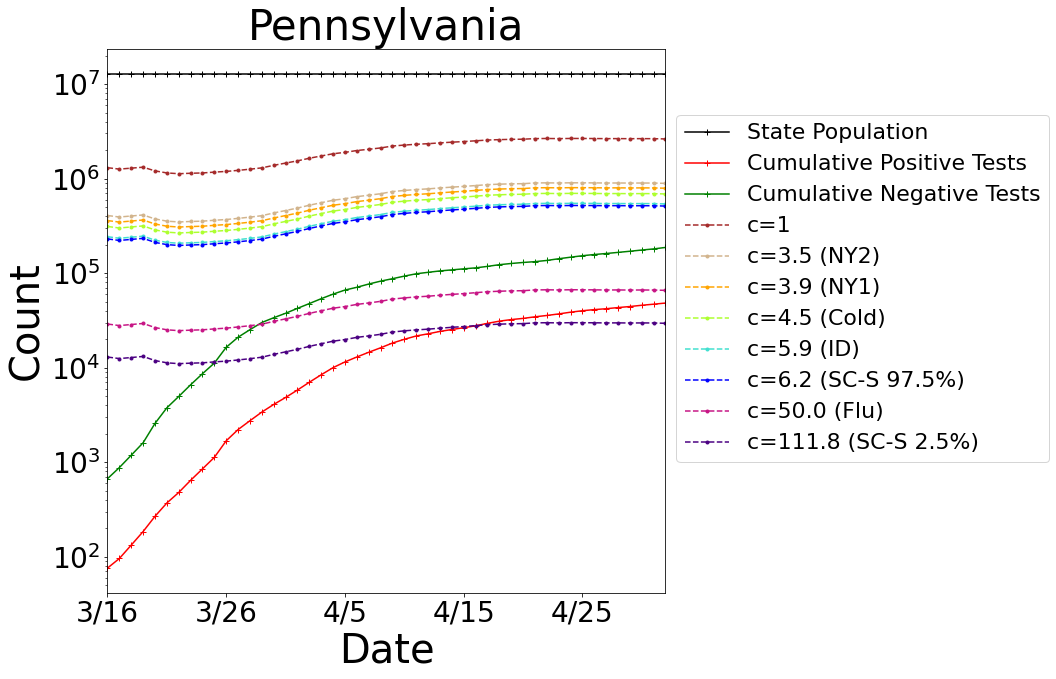

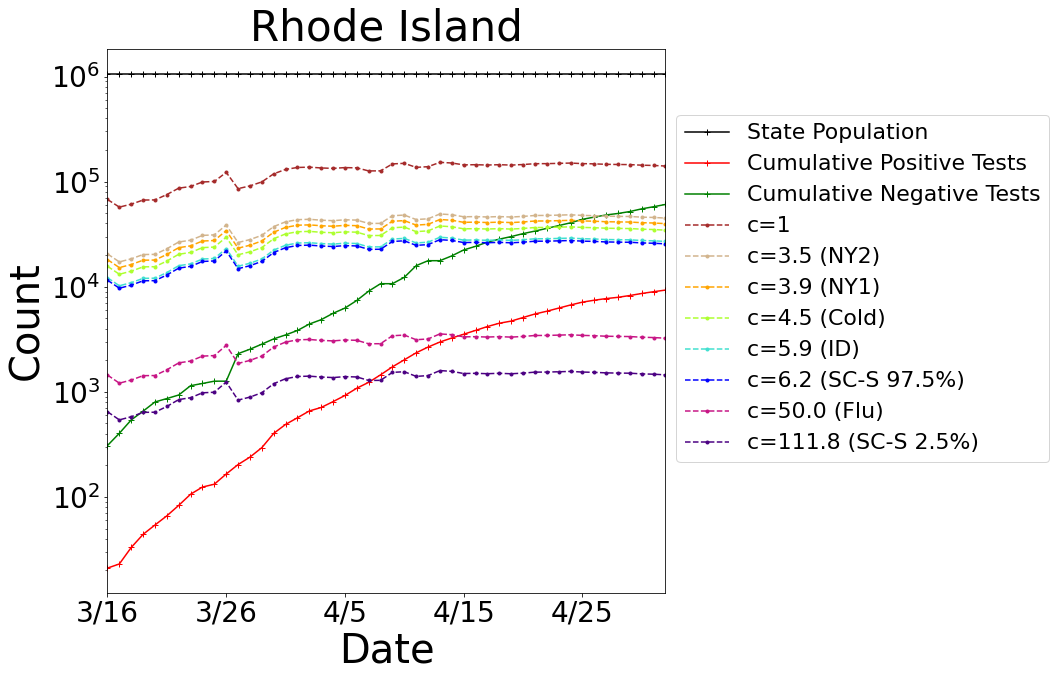

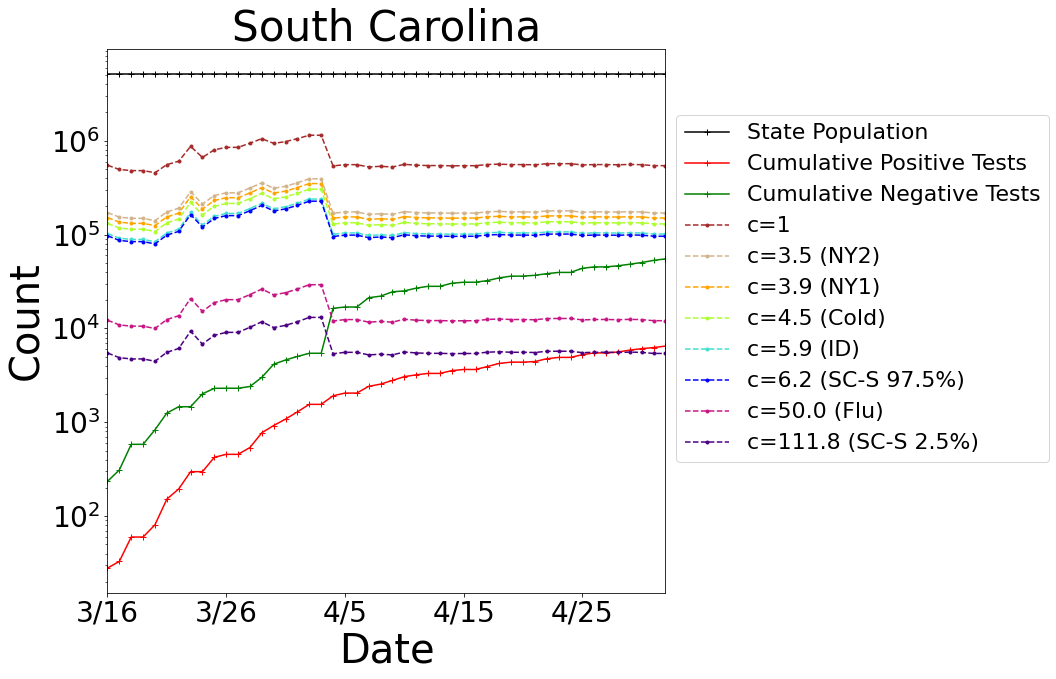

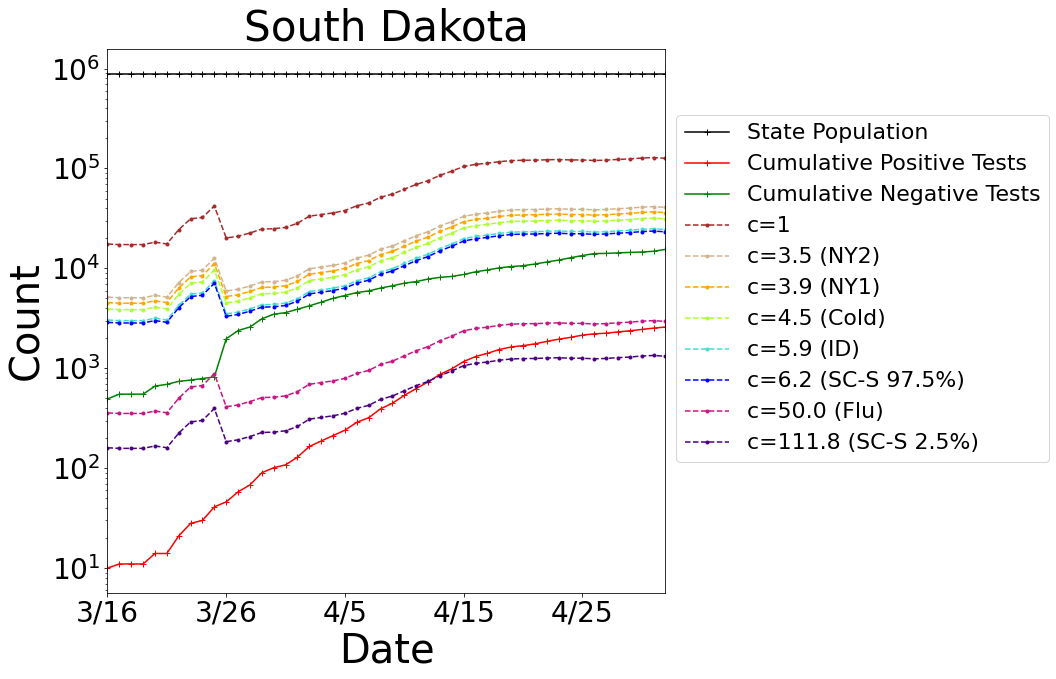

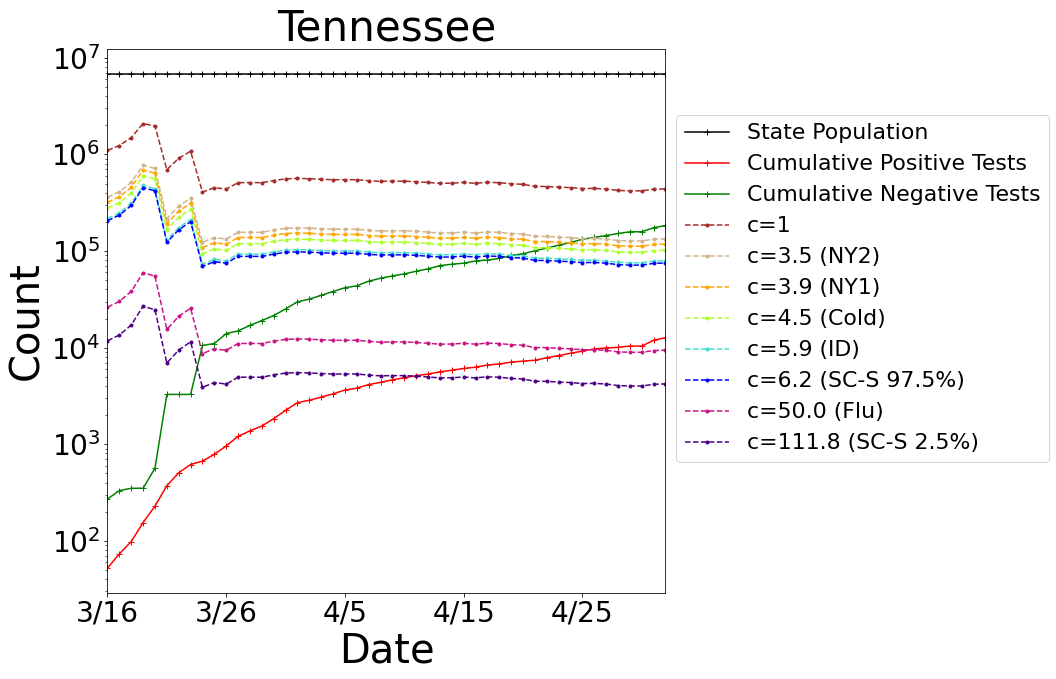

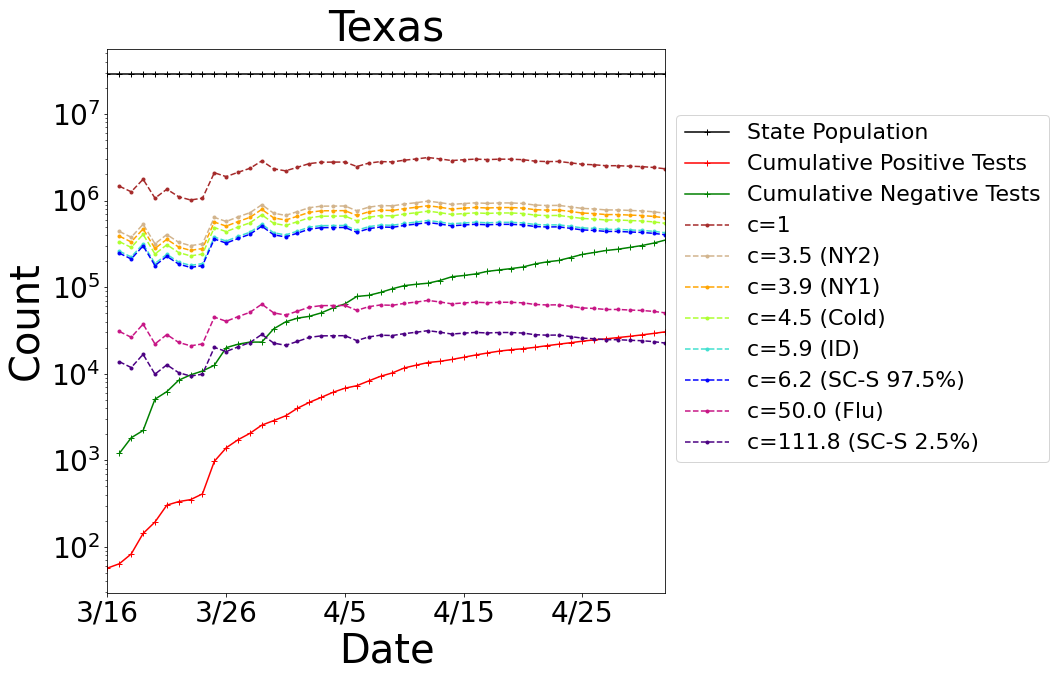

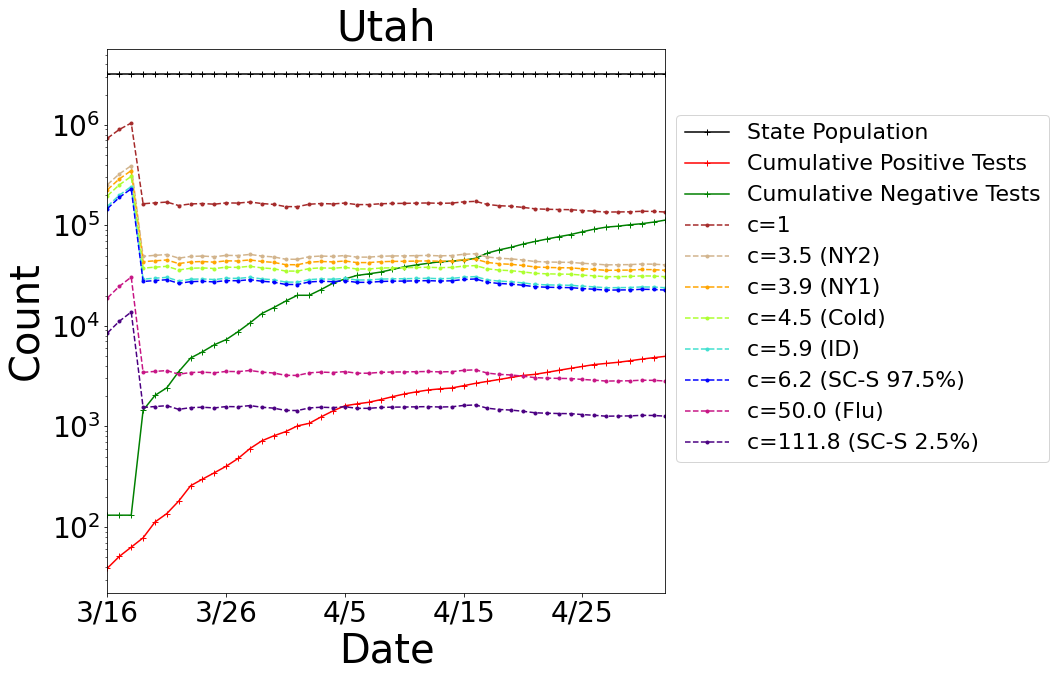

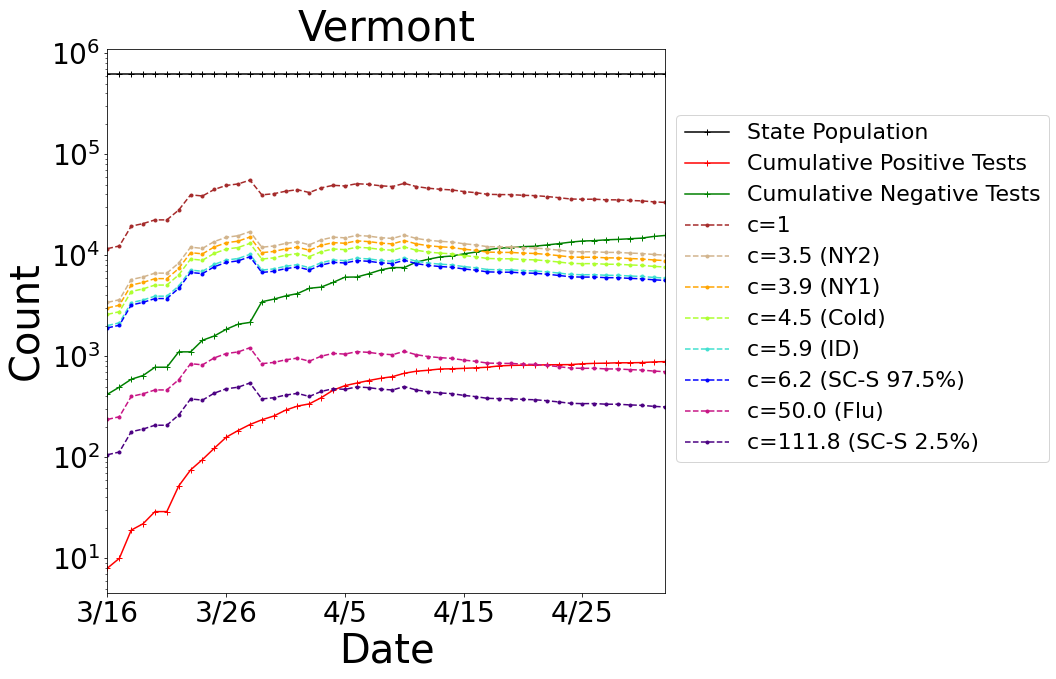

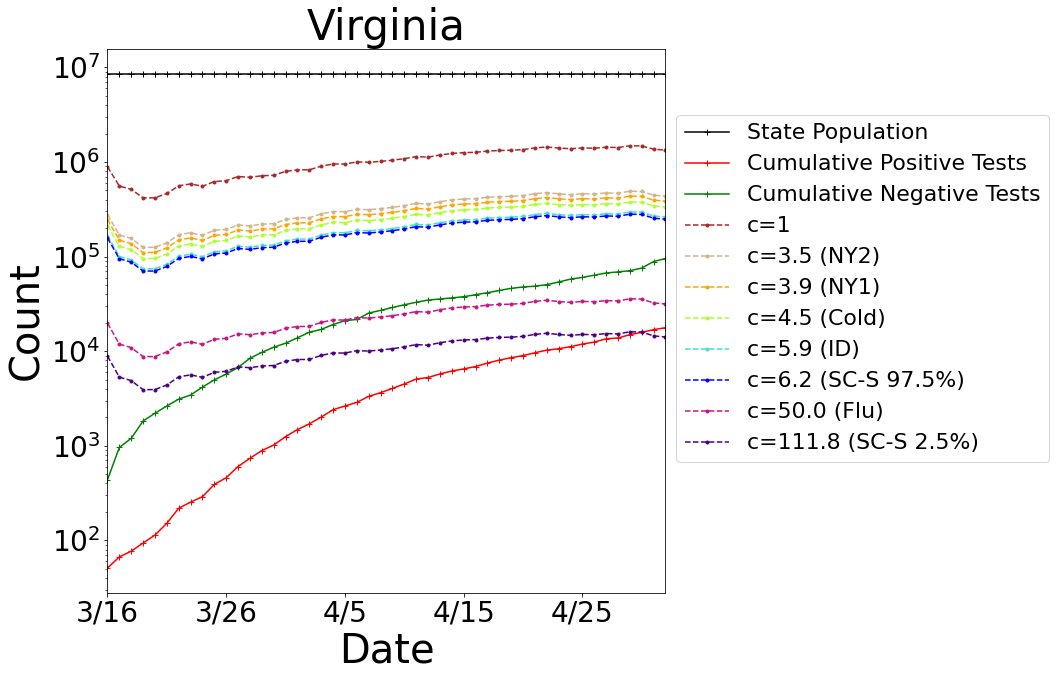

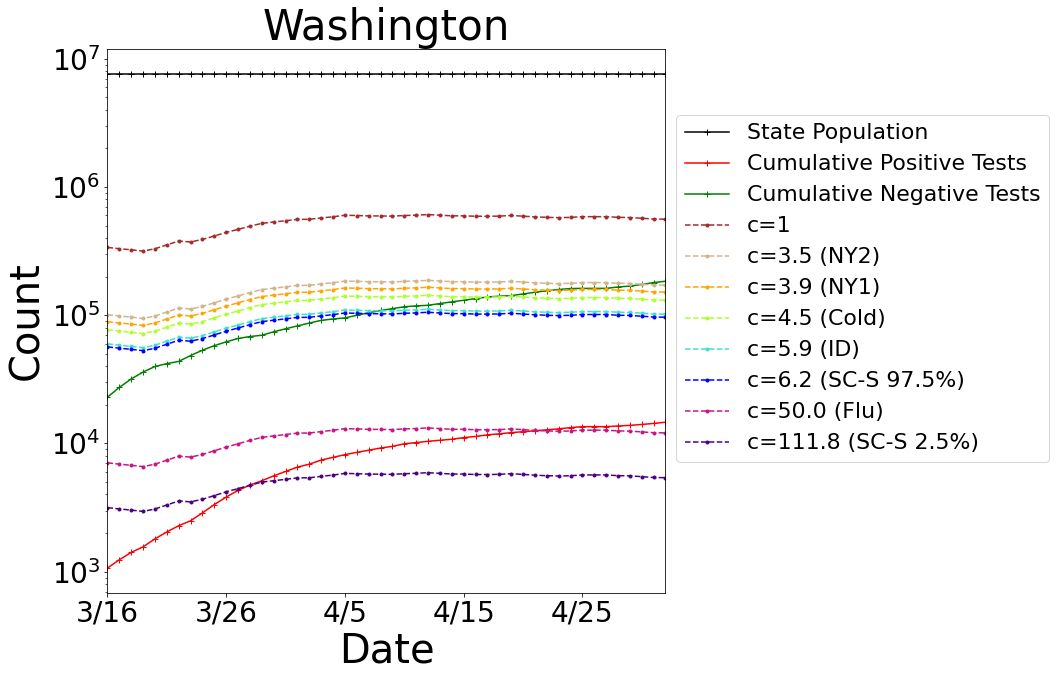

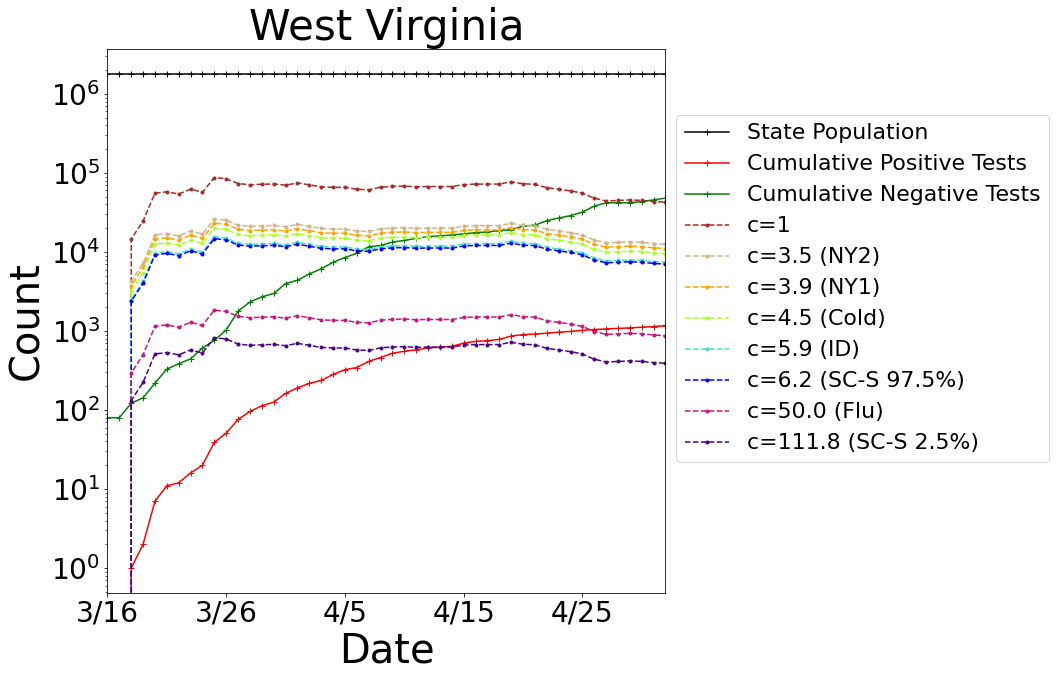

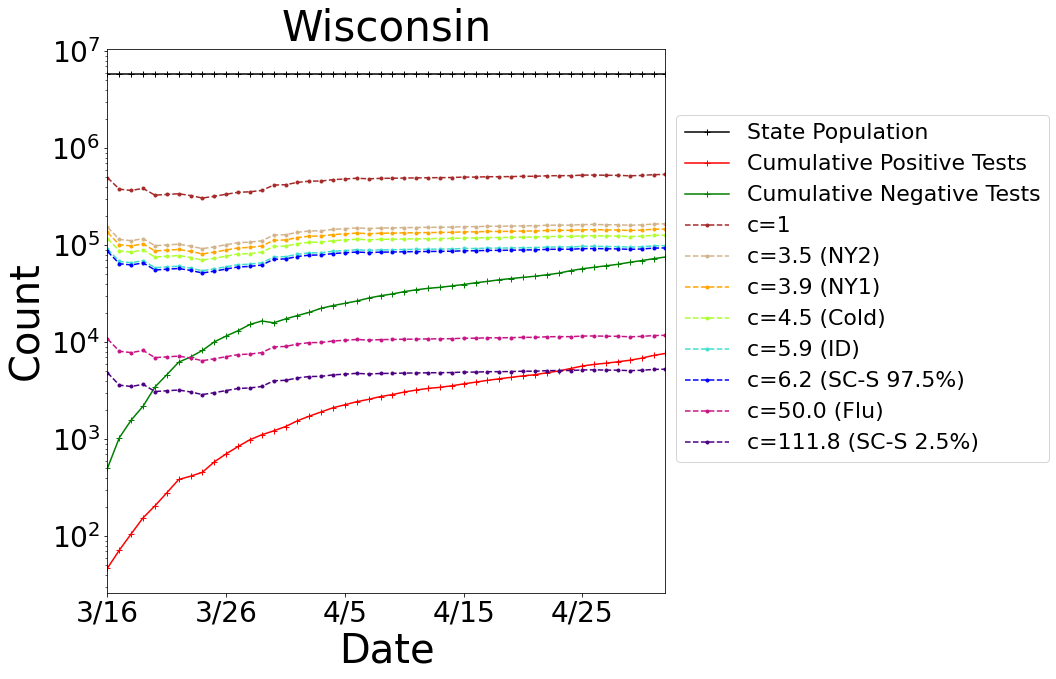

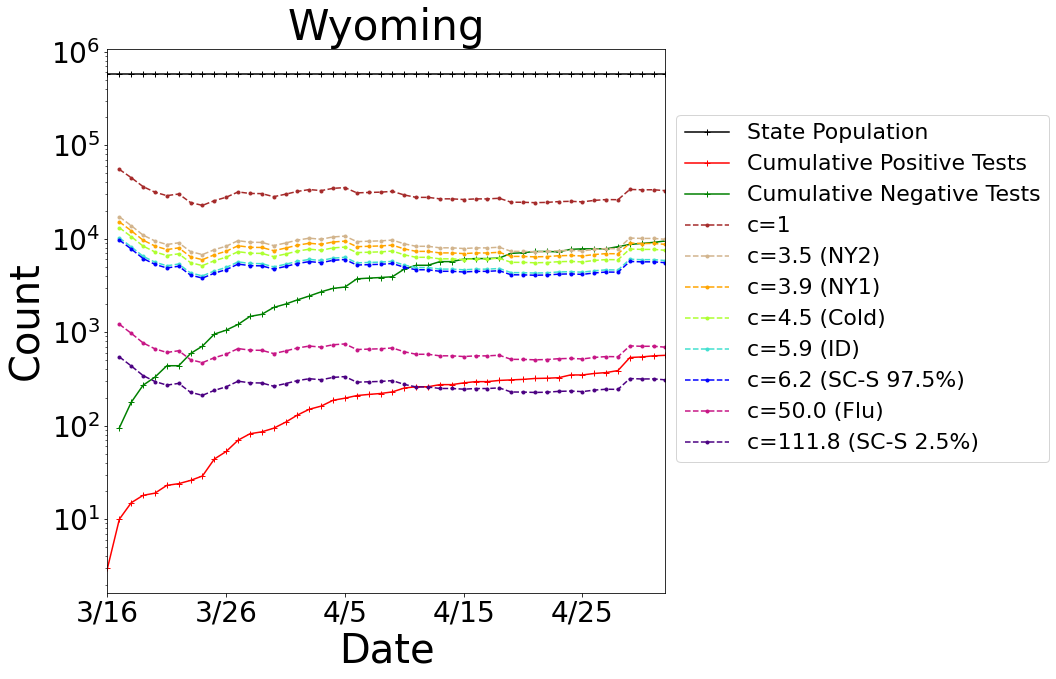

In [20]:
#colors = ['blue', 'orange', 'indigo', 'brown', 'mediumvioletred', 'turquoise', 'tan']
colors = ['brown', 'tan', 'orange', 'greenyellow', 'turquoise', 'blue', 'mediumvioletred', 'indigo']
def plot_for_cs(state, cs, save_dir):
    plot_pos_neg_pop(state, dates)
    print(state)
    plt.title(state_full_names[state], fontsize=42)
    for i, (c_name, c_key) in enumerate(cs.items()):
        try:
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.semilogy(latent_totals, color=colors[i], label='{}'.format(c_name), linestyle='--', marker=markers[0])
    finalize_plot(dates, "Count", "{}/{}.pdf".format(save_dir, state), separate_legend=True)

for state in state_pops.keys():
    # Plot estimated total infections based on static c
    fig = plt.figure(figsize=(10, 10))
    plot_for_cs(state, {'c=1': 1, 
                        'c={:.1f} (NY2)'.format(c_nyc_new): c_nyc_new,
                        'c={:.1f} (NY1)'.format(c_nyc_mean): c_nyc_mean,
                        #'c={:.2f} (NY Upper)'.format(c_nyc_upper): c_nyc_upper,
                        #'c={:.2f} (FL Mean)'.format(c_flo): c_flo,
                        #'c=Dynamic': lambda j: linear(0, n_dates-1, c_stanford_lower, c_flo, j),
                        'c={:.1f} (Cold)'.format(c_cold): c_cold, 
                        'c={:.1f} (ID)'.format(c_idaho): c_idaho,
                        'c={:.1f} (SC-S 97.5%)'.format(c_stanford_max): c_stanford_max,
                        'c={:.1f} (Flu)'.format(c_flu): c_flu,
                        "c={:.1f} (SC-S 2.5%)".format(c_stanford_min): c_stanford_min,
                        #'Required Symptoms: Bad Flu': c_bad_flu,
                        #'Required Symptoms: Flu->Cold': lambda j: logistic(0, n_dates-1, c_flu, c_cold, j, 10),
                        #'Required Symptoms: Bad Flu->Flu': lambda j: logistic(0, n_dates-1, c_bad_flu, c_flu, j, 10)
                },
               "results/")